In [31]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
`
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


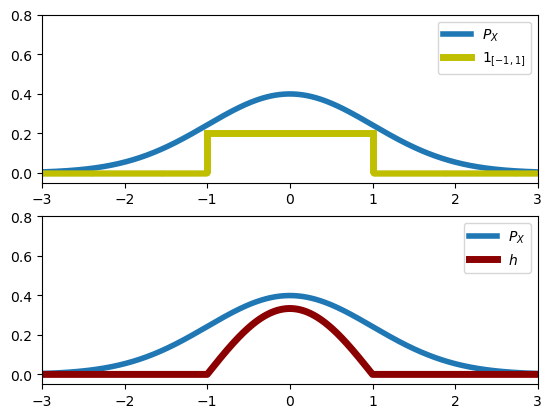

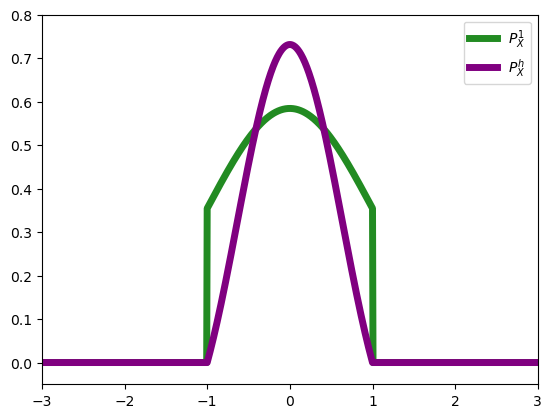

In [3]:
fig = plt.figure()
ax = fig.subplots(nrows=2, ncols=1)

x = np.linspace(-3, 3, 1000)

indic = (x <= 1) & (x >= -1)
ax[0].plot(x, norm.pdf(x), label=f"$P_X$", linewidth=4)
ccdf = norm.cdf(1) - norm.cdf(-1)
ax[0].plot(x[indic], np.ones_like(x[indic]) * 0.2, color='y', linewidth=5, label=f"$1_{{[-1,1]}}$")
ax[0].vlines(-1, ymin=0, ymax=0.2, color='y', linewidth=5)
ax[0].vlines(1, ymin=0, ymax=0.2, color='y', linewidth=5)
ax[0].plot(x[~indic], np.zeros_like(x[~indic]), '.', color='y', linewidth=5)
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-0.05, 0.8)
ax[0].legend()
# ax[0,0].savefig('indic_tilt.pdf')

ax[1].plot(x, norm.pdf(x), label=f"$P_X$", linewidth=4)
tilt = np.maximum(np.cos(np.pi/2*x), np.zeros_like(np.cos(x)))/ 3
ax[1].plot(x, tilt, color='darkred', linewidth=5, label=f"$h$")
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-0.05, 0.8)
ax[1].legend()
fig.savefig('figures/tilts.pdf')


plt.figure()
plt.xlim(-3, 3)
plt.ylim(-0.05, 0.8)
zeros = np.zeros_like(x)
zeros[indic] = 1
plt.plot(x, (norm.pdf(x) * zeros) /ccdf, color='forestgreen', label=f"$P^1_X$", linewidth=5)
plt.plot(x, (norm.pdf(x) * tilt) * 5.5, color='purple', label=f"$P^h_X$", linewidth=5)
plt.legend()
plt.savefig('figures/tilted_dist.pdf')



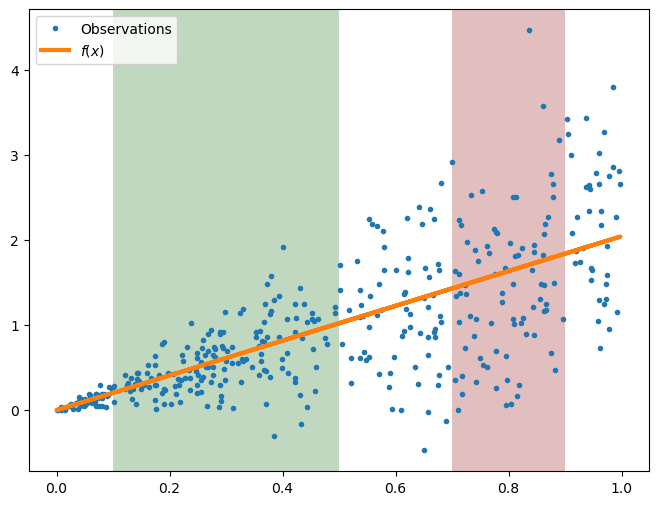

In [4]:
rng = np.random.default_rng(seed=3)

n = 1000
theta_0 = rng.standard_normal()
x = rng.uniform(0, 1, n)
y = rng.normal(theta_0 * x, np.abs(x))

theta_hat, _, _, _ = np.linalg.lstsq(x.reshape(-1,1), y, rcond=None)

s = 400
x = rng.uniform(0, 1, s)
y = rng.normal(theta_0 * x, np.abs(x))
plt.figure(figsize=(8,6))
plt.plot(x, y, '.', label='Observations')
plt.plot(x, x * theta_hat, lw=3, label=f'$f(x)$')
plt.axvspan(0.1, 0.5, facecolor='darkgreen', alpha=0.25)
plt.axvspan(0.7, 0.9, facecolor='darkred', alpha=0.25)
plt.legend()
# plt.savefig('figures/olsh_certificates.pdf')

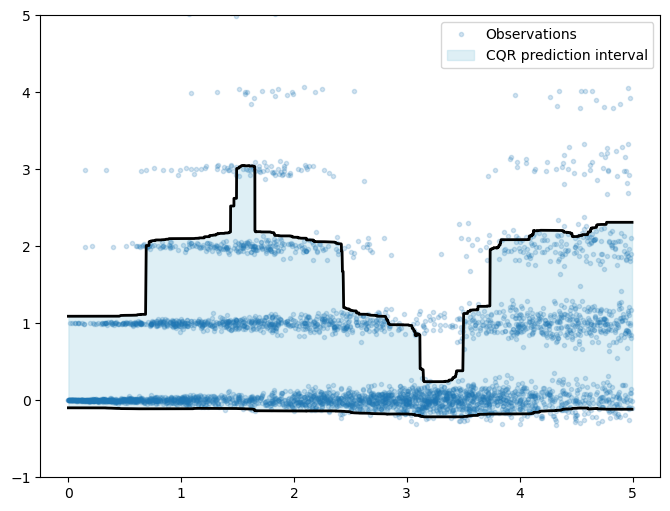

In [369]:
import pandas as pd

audit_trail = pd.read_csv('../data/oos_data.csv', index_col=0)

rng = np.random.default_rng(seed=0)

sample_size = 4000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]

plt.figure(figsize=(8,6))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.2, label='Observations')
plt.plot(X, Z1, color='k', lw=2)
plt.plot(X, Z2, color='k', lw=2)
plt.fill_between(X, Z1, Z2, color='lightblue', alpha=0.4, label='CQR prediction interval')
# plt.axvspan(0.8, 1.5, facecolor='darkred', alpha=0.25)
# plt.axvspan(2.3, 3.4, facecolor='darkred', alpha=0.25)
plt.ylim(-1,5)
plt.legend()
# plt.savefig('cqr_interval.pdf')

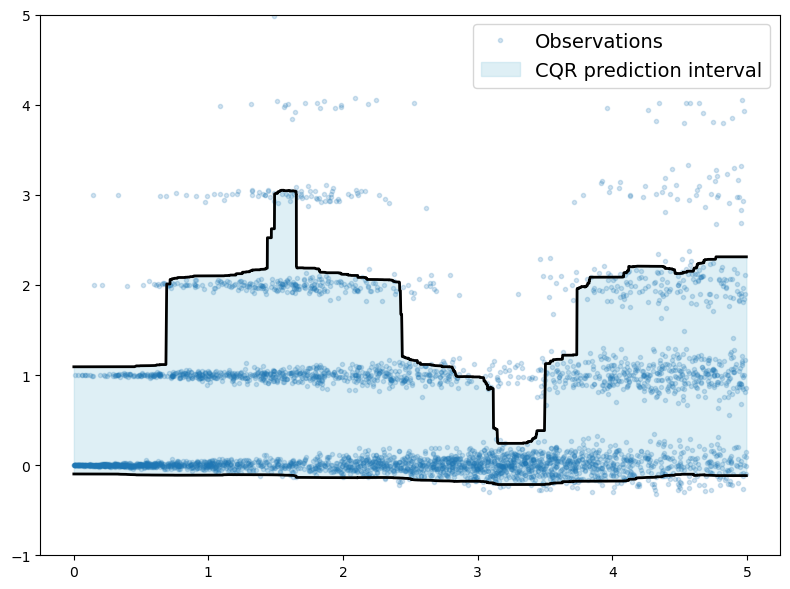

In [370]:
import pandas as pd

plt.rcParams.update({'font.size': 10})

audit_trail = pd.read_csv('../data/oos_data.csv', index_col=0)

rng = np.random.default_rng(seed=0)

sample_size = 4000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]

plt.figure(figsize=(8,6))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.2, label='Observations')
plt.plot(X, Z1, color='k', lw=2)
plt.plot(X, Z2, color='k', lw=2)
plt.fill_between(X, Z1, Z2, color='lightblue', alpha=0.4, label='CQR prediction interval')
# plt.axvspan(0.8, 1.5, facecolor='darkred', alpha=0.25)
# plt.axvspan(2.3, 3.4, facecolor='darkred', alpha=0.25)
plt.ylim(-1,5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('figures/cqr_interval.pdf')

In [371]:
from fairaudit import Auditor, Metric

auditor = Auditor(
    X=X.reshape(-1,1),
    Y=Y,
    Z=np.concatenate([Z1.reshape(-1,1), Z2.reshape(-1,1)], axis=1),
    metric=Metric('equalized_coverage')
)


from fairaudit.groups import get_rectangles

discretization = np.arange(0, 5, 0.1)
intervals_at = get_rectangles(X.reshape(-1,1), {0:discretization})

auditor.calibrate_groups(
    alpha=0.1,
    type='upper',
    groups=intervals_at,
    bootstrap_params={'seed': 0, 'student': 'prob_bound', 'student_threshold': 0.01**(3/2)}
)

auditor_bad = Auditor(
    X=X.reshape(-1,1),
    Y=Y,
    Z=np.concatenate([Z1.reshape(-1,1), Z2.reshape(-1,1)], axis=1),
    metric=Metric('equalized_coverage')
)

auditor_bad.calibrate_groups(
    alpha=0.1,
    type='upper',
    groups=intervals_at,
    bootstrap_params={'seed': 0}
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 92.54it/s]


0.8594162721576839
0.7869340387858513
0.7599844370549175
0.8392256311084232
0.9161285162230084


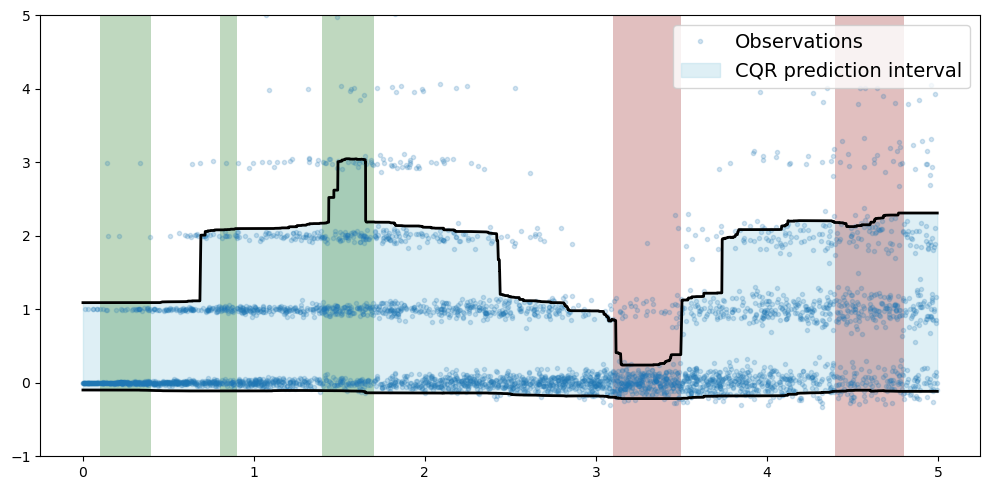

In [372]:
plt.figure(figsize=(10,5))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.2, label='Observations')
plt.plot(X, Z1, color='k', lw=2)
plt.plot(X, Z2, color='k', lw=2)
plt.fill_between(X, Z1, Z2, color='lightblue', alpha=0.4, label='CQR prediction interval')


g_1 = (0.8, 0.9)
g_2 = (3.1, 3.5)
g_3 = (4.4, 4.8)
g_4 = (1.4, 1.7)
g_5 = (0.1, 0.4)
groups = (g_1, g_2, g_3, g_4, g_5)

for g in groups:
    group = (X <= g[1]) & (X >= g[0])

    bound, raw_val, threshold = auditor.query_group(group)
    print(bound[0])
    if bound[0] >= 0.8:
        color = 'darkgreen'
    else:
        color = 'darkred'
    plt.axvspan(g[0], g[1], facecolor=color, alpha=0.25)
    
plt.ylim(-1,5)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.savefig("figures/highlighted_cqr_interval.pdf")

In [60]:
from tqdm import tqdm
widths = []
bounds = []
bounds_bad = []
values = []
for ind in tqdm(intervals_at.T):
    x_vals = X[ind]
    width = np.round(x_vals.max() - x_vals.min(), 1)
    bound, value, _ = auditor.query_group(ind)
    bound_bad, value, _ = auditor_bad.query_group(ind)
    widths.append(width)
    bounds.append(np.clip(bound[0], 0, 1))
    bounds_bad.append(np.clip(bound_bad[0], 0, 1))
    values.append(value[0])
    
pd.DataFrame(dict(width=widths, bound=bounds, bound_bad=bounds_bad, value=values))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:15<00:00, 81.98it/s]


,width,bound,bound_bad,value
0,0.1,0.693524,0.000000,0.808219
1,0.1,0.707222,0.000000,0.821918
2,0.2,0.733967,0.000000,0.815068
3,0.1,0.743166,0.000000,0.848837
4,0.2,0.758762,0.000000,0.836478
...,...,...,...,...
1270,4.6,0.893460,0.901525,0.909583
1271,4.7,0.892210,0.900430,0.908174
1272,4.8,0.891065,0.899447,0.906850
1273,4.9,0.889633,0.898141,0.905271


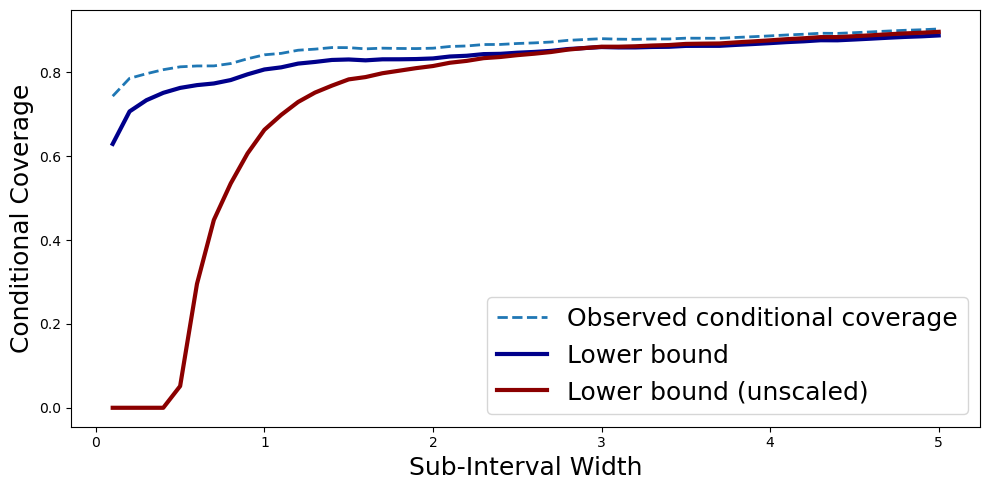

In [320]:
lower_bounds = pd.DataFrame(dict(width=widths, bound=bounds, bound_bad=bounds_bad, value=values)).groupby("width").min()
lower_bounds = lower_bounds[lower_bounds['bound'] >= 0.3]
plt.figure(figsize=(10, 5))
plt.plot(lower_bounds.index, lower_bounds['value'], '--', lw=2, 
         label="Observed conditional coverage")
plt.plot(lower_bounds.index, lower_bounds['bound'], lw=3, color='darkblue', 
         label="Lower bound")
plt.plot(lower_bounds.index, lower_bounds['bound_bad'][::-1].cummin()[::-1], lw=3, color='darkred', 
         label="Lower bound (unscaled)")
plt.xlabel("Sub-Interval Width", size=18)
plt.ylabel("Conditional Coverage", size=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig("figures/bound_cqr_interval_2.pdf")

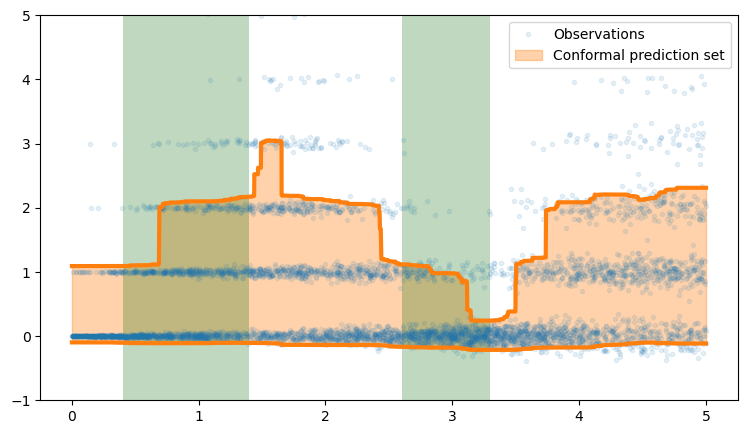

In [14]:
import pandas as pd

audit_trail = pd.read_csv('../data/oos_data.csv', index_col=0)

rng = np.random.default_rng(seed=0)

sample_size = 5000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]

plt.figure(figsize=(9,5))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.1, label='Observations')
plt.plot(X, Z1, color='#ff7f0e', lw=3)
plt.plot(X, Z2, color='#ff7f0e', lw=3)
plt.fill_between(X, Z1, Z2, color='#ff7f0e', alpha=0.35, label='Conformal prediction set')
plt.axvspan(0.4, 1.4, facecolor='darkgreen', alpha=0.25)
plt.axvspan(2.6, 3.3, facecolor='darkgreen', alpha=0.25)
plt.ylim(-1,5)
plt.legend()
plt.savefig('figures/cqr_preview.pdf')

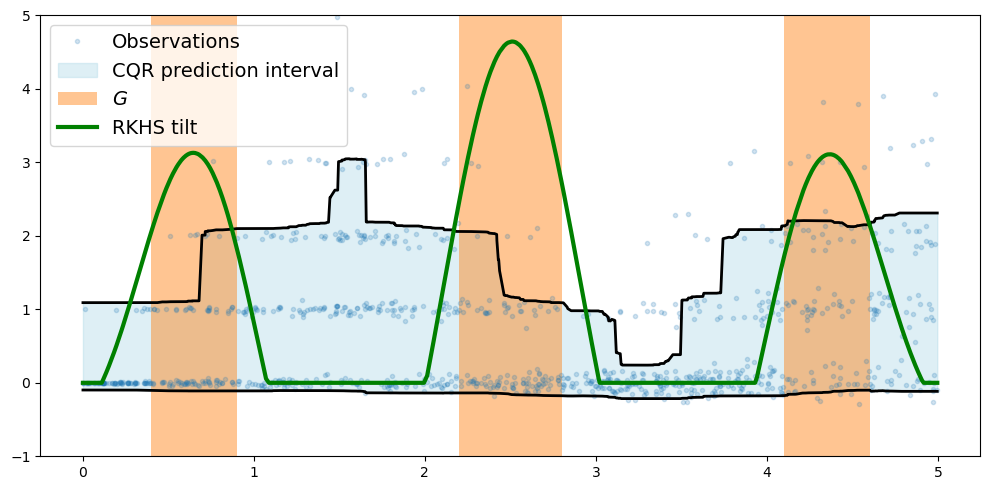

In [315]:
import cvxpy as cp
from sklearn.metrics.pairwise import pairwise_kernels

rng = np.random.default_rng(seed=0)

sample_size = 1000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)
s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx].reshape(-1,1)
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]

sd = 0.5
K = pairwise_kernels(X, metric='rbf', **{'gamma' : 1/sd**2}) + 1e-6 * np.eye(len(X))

L = np.linalg.cholesky(K)

w = cp.Variable((len(X), 1))
c = cp.Variable()

filters = (X <= 2.8) & (X >= 2.2) 
filters |= (X >= 0.4) & (X <= 0.9) 
filters |= (X >= 4.1) & (X <= 4.6) 

target = 10* (filters).astype(int) - 3


plt.figure(figsize=(10,5))
plt.plot(audit_trail_sample['x'], audit_trail_sample['y'], '.', alpha=0.2, label='Observations')
plt.plot(X.flatten(), Z1, color='k', lw=2)
plt.plot(X.flatten(), Z2, color='k', lw=2)
plt.fill_between(X.flatten(), Z1, Z2, color='lightblue', alpha=0.4, label='CQR prediction interval')
# plt.plot(X.flatten(), filters.astype(int) * 3, '.')
plt.axvspan(0.4, 0.9, facecolor='#ff7f0e', alpha=0.45, label=f'$G$')
plt.axvspan(2.2, 2.8, facecolor='#ff7f0e', alpha=0.45)
plt.axvspan(4.1, 4.6, facecolor='#ff7f0e', alpha=0.45)

plt.ylim(-1, 5)

lmbda = 1
obj = cp.Minimize(cp.sum_squares(L @ w - target) - lmbda * c)
constraints = [cp.norm(w) <= 1, cp.sum(L @ w) >= c]
prob = cp.Problem(obj, constraints)
prob.solve(solver='MOSEK')

real_w = np.linalg.solve(L.T, w.value/np.linalg.norm(w.value))

plt.plot(X.flatten(), 8 * (K @ real_w).clip(0), color='green', lw=3, label='RKHS tilt')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('figures/interval_union_rkhs_fit.pdf')

In [22]:
auditor = Auditor(
    X=X,
    Y=Y,
    Z=np.concatenate((Z1.reshape(-1,1), Z2.reshape(-1,1)), axis=1),
    metric=Metric('equalized_coverage')
)


In [23]:
discretization = np.arange(0, 5, 0.1)
intervals_at = get_rectangles(X, {0:discretization})

auditor.calibrate_groups(
    alpha=0.1,
    type='upper',
    groups=intervals_at,
    bootstrap_params={'seed': 0, 'student': 'prob_bound', 'student_threshold': 0.1**(3/2)}
)

filters1 = (X <= 2.6) & (X >= 2.2) 
filters2 = (X >= 0.5) & (X <= 0.8) 
filters3 = (X >= 4.2) & (X <= 4.6) 
filters4 = (X >= 3.3) & (X <= 3.6) 


print(auditor.query_group(filters1))
print(auditor.query_group(filters2))
print(auditor.query_group(filters3))
print(auditor.query_group(filters4))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 303.47it/s]


([0.7823497017908339], [0.9333333333333333], [0])
([0.706655850988521], [0.9206349206349206], [0])
([0.6351505108976243], [0.7945205479452054], [0])
([0.6042253880641547], [0.782608695652174], [0])


In [24]:
auditor.calibrate_rkhs(
    alpha=0.1,
    type='upper',
    kernel='rbf',
    kernel_params={'gamma': 1/sd**2},
    bootstrap_params={'seed': 0}
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.12it/s]


In [28]:
auditor.query_rkhs(real_w)

([0.75980063120083], [0.9079999999999996])

In [50]:
dataset = pd.read_csv('../data/compas_bounds.csv', index_col=0)

aa_dataset = dataset[dataset['races'] == "African-American"]#.sort_values(by='races')
all_dataset = dataset[dataset['races'] == "all"]
all_dataset

race_dataset = dataset[(dataset['ages'] == "all") & (dataset['sexes'] == "all")]
race_dataset

,races,ages,sexes,lowers,uppers
0,African-American,all,all,0.009904,0.100508
1,Hispanic,all,all,-0.195910,0.130412


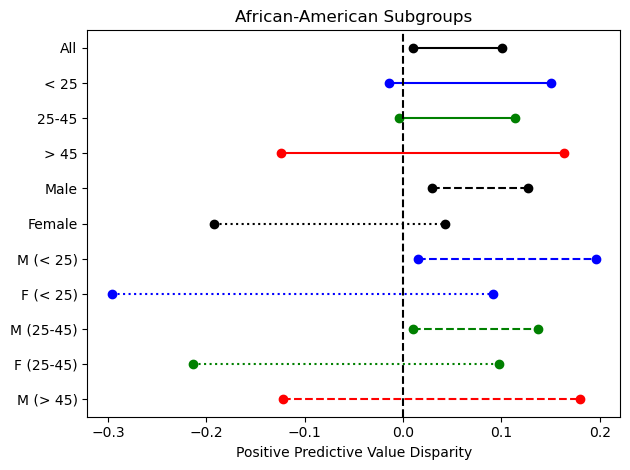

In [79]:
aa_indices = [0, 9, 7, 8, 14, 13, 29, 28, 25, 24, 27]
all_indices = [4, 2, 3, 6, 5, 23, 22, 19, 18, 21, 20]
def get_color(age):
    if age == "Less than 25":
        return 'blue'
    elif age == "25 - 45":
        return 'g'
    elif age == "Greater than 45":
        return 'r'
    return 'black'

def get_linestyle(sex):
    if sex == "Male":
        return "dashed"
    elif sex == "Female":
        return "dotted"
    return "solid"

def simplify(x):
    if x == "Male":
        return "M"
    if x == "Female":
        return "F"
    if x == "Less than 25":
        return "< 25"
    if x == "25 - 45":
        return "25-45"
    if x == "Greater than 45":
        return "> 45"

labels = []
for y, idx in enumerate(aa_indices[::-1]):
    row = aa_dataset.loc[idx]
    lower = row[3]
    upper = row[4]
    color = get_color(row[1])
    linestyle = get_linestyle(row[2])
    if row[1] == 'all':
        if row[2] == 'all':
            labels.append('All')
        else:
            labels.append(f'{row[2]}')
    elif row[2] == 'all':
        labels.append(f'{simplify(row[1])}')
    else:
        labels.append(f'{simplify(row[2])} ({simplify(row[1])})')
    plt.plot((lower,upper),(y,y),'o',color=color, linestyle=linestyle)

plt.yticks(range(len(all_indices)),labels)
plt.axvline(0, color='black', linestyle='--')
plt.title("African-American Subgroups")
plt.xlabel("Positive Predictive Value Disparity")
plt.tight_layout()
plt.savefig('figures/ppv_intervals_afam.pdf')

In [364]:
# create ci calibration plot for slides

audit_trail = pd.read_csv('../data/oos_data.csv', index_col=0)

rng = np.random.default_rng(seed=0)

sample_size = 4000
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]
coverage = ((Y <= Z2) & (Y >= Z1)).astype(int)


auditor = Auditor(
    X=X.reshape(-1,1),
    Y=Y,
    Z=np.concatenate([Z1.reshape(-1,1), Z2.reshape(-1,1)], axis=1),
    metric=Metric('equalized_coverage')
)


from fairaudit.groups import get_rectangles

discretization = np.arange(0, 5, 0.1)
intervals_at = get_rectangles(X.reshape(-1,1), {0:discretization})

auditor.calibrate_groups(
    alpha=0.1,
    type='upper',
    groups=intervals_at,
    bootstrap_params={'seed': 0}
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 84.95it/s]


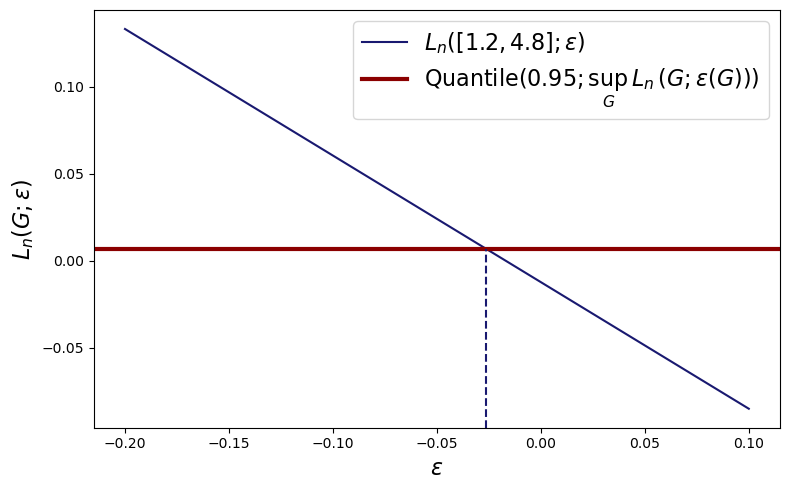

In [335]:
subinterval_1 = (X <= 4.8) & (X >= 1.2)
subinterval_2 = (X <= 3.5) & (X >= 2.2)
subinterval_3 = (X <= 1.1) & (X >= 0.6)

bound_1, est_1, _ = auditor.query_group(subinterval_1.reshape(-1,1))
eps = np.linspace(-0.2, 0.1, 1000)
statistic1 = np.mean((coverage - np.mean(coverage)) * subinterval_1) - eps * np.mean(subinterval_1)
statistic2 = np.mean((coverage - np.mean(coverage)) * subinterval_2) - eps * np.mean(subinterval_2)
statistic3 = np.mean((coverage - np.mean(coverage)) * subinterval_3) - eps * np.mean(subinterval_3)
t = auditor.critical_values[0]
plt.figure(figsize=(8, 5))
lines_1 = plt.plot(eps, statistic1, label=f"$L_n([1.2, 4.8]; \epsilon)$", color='midnightblue')
# lines_2 = plt.plot(eps, statistic2, label=f"$L_n([2.2, 3.5]; \epsilon)$", color='royalblue')
# lines_3 = plt.plot(eps, statistic3, label=f"$G_3 = [0.6, 1.1]$")
plt.axhline(t, color='darkred', lw=3, label=f'Quantile$(0.95; \sup_G\,L_n(G; \epsilon(G))$)')
plt.tight_layout()
plt.ylabel(f"$L_n(G; \epsilon)$", size=16)
plt.xlabel(f"$\epsilon$", size=16)
plt.legend(fontsize=16)

ymin, ymax = plt.gca().get_ybound()
ymax = (t - ymin) / (ymax - ymin)
plt.axvline((np.mean((coverage - np.mean(coverage)) * subinterval_1) - t) / np.mean(subinterval_1), ymax=ymax, 
            ls='--', color=lines_1[0].get_color())
# plt.axvline((np.mean((coverage - np.mean(coverage)) * subinterval_2) - t) / np.mean(subinterval_2), ymax=ymax, 
#             ls='--', color=lines_2[0].get_color())
# plt.axvline((np.mean((coverage - np.mean(coverage)) * subinterval_3) - t) / np.mean(subinterval_3), 
# ymax=ymax, ls='--', color=lines_3[0].get_color())
plt.tight_layout()
plt.savefig('figures/bound_calibration_primer_1.pdf')

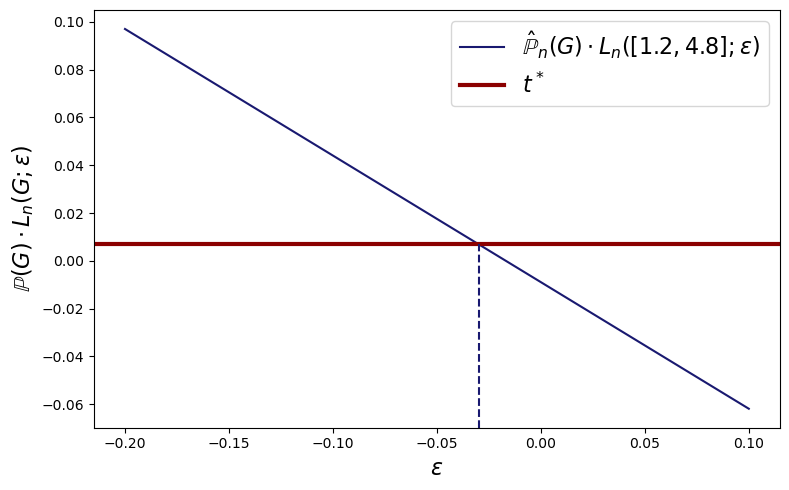

In [367]:
subinterval_1 = (X <= 4.8) & (X >= 1.2)
subinterval_2 = (X <= 3.5) & (X >= 2.2)
subinterval_3 = (X <= 1.1) & (X >= 0.6)

bound_1, est_1, _ = auditor.query_group(subinterval_1.reshape(-1,1))
eps = np.linspace(-0.2, 0.1, 1000)
statistic1 = np.mean((coverage - np.mean(coverage)) * subinterval_1) - eps * np.mean(subinterval_1)
statistic2 = np.mean((coverage - np.mean(coverage)) * subinterval_2) - eps * np.mean(subinterval_2)
statistic3 = np.mean((coverage - np.mean(coverage)) * subinterval_3) - eps * np.mean(subinterval_3)
t = auditor.critical_values[0]
plt.figure(figsize=(8, 5))
lines_1 = plt.plot(eps, np.mean(subinterval_1) * statistic1, label=f"$\hat{{\mathbb{{P}}}}_n(G) \cdot L_n([1.2, 4.8]; \epsilon)$", color='midnightblue')
# lines_2 = plt.plot(eps, statistic2, label=f"$L_n([2.2, 3.5]; \epsilon)$", color='royalblue')
# lines_3 = plt.plot(eps, statistic3, label=f"$G_3 = [0.6, 1.1]$")
plt.axhline(t, color='darkred', lw=3, label=f'$t^*$')
plt.tight_layout()
plt.ylabel(f"$\mathbb{{P}}(G) \cdot L_n(G; \epsilon)$", size=16)
plt.xlabel(f"$\epsilon$", size=16)
plt.legend(fontsize=16)

ymin, ymax = plt.gca().get_ybound()
ymax = (t - ymin) / (ymax - ymin)
plt.axvline(np.mean((coverage - np.mean(coverage)) * subinterval_1) / np.mean(subinterval_1) - t / np.mean(subinterval_1)**2, ymax=ymax, 
            ls='--', color=lines_1[0].get_color())
# plt.axvline((np.mean((coverage - np.mean(coverage)) * subinterval_2) - t) / np.mean(subinterval_2), ymax=ymax, 
#             ls='--', color=lines_2[0].get_color())
# plt.axvline((np.mean((coverage - np.mean(coverage)) * subinterval_3) - t) / np.mean(subinterval_3), 
# ymax=ymax, ls='--', color=lines_3[0].get_color())
plt.tight_layout()
plt.savefig('figures/bound_calibration_primer.pdf')

In [220]:
# generate bootstrap histogram for CQR example
from fairaudit.groups import get_rectangles

plt.rcParams.update({'font.size': 10})

discretization = np.arange(0, 5, 0.1)
audit_trail = pd.read_csv('../data/oos_data.csv', index_col=0)
pop_x = audit_trail['x'].to_numpy()
pop_y = audit_trail['y'].to_numpy()
pop_z1 = audit_trail['z1'].to_numpy()
pop_z2 = audit_trail['z2'].to_numpy()

# O(1) minutes to run
pop_intervals = get_rectangles(pop_x.reshape(-1,1), {0:discretization})
pop_coverage = (pop_y <= pop_z2) & (pop_y >= pop_z1)

In [231]:
P_mapper = {}
L_mapper = {}
for idx in range(pop_intervals.shape[1]):
    subint = pop_x[pop_intervals[:,idx]]
    x_min = subint.min().round(1)
    x_max = subint.max().round(1)
    L_mapper[(x_min, x_max)] = np.mean(pop_coverage * pop_intervals[:,idx])
    P_mapper[(x_min, x_max)] = np.mean(pop_intervals[:,idx])
    


In [341]:
rng = np.random.default_rng(seed=0)

def generate_statistic(sample_size=1000):
    audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

    X = audit_trail_sample['x'].to_numpy()
    Y = audit_trail_sample['y'].to_numpy()
    Z1 = audit_trail_sample['z1'].to_numpy()
    Z2 = audit_trail_sample['z2'].to_numpy()
    
    coverage = (Y <= Z2) & (Y >= Z1)
        
    max_statistic = -np.inf
    
    for (x_min, x_max) in L_mapper.keys():
        x_filter = (X <= x_max) & (X >= x_min)
        subint = X[x_filter]
        
        L_n = np.mean(coverage * x_filter)
        P_n = np.mean(x_filter)
        L = L_mapper[(x_min, x_max)]
        P = P_mapper[(x_min, x_max)]
        
        statistic = L_n * P - L * P_n
        if statistic > max_statistic:
            max_statistic = statistic
    return max_statistic

sample_size = 200
true_statistics = [generate_statistic(sample_size) for i in range(1000)]

In [342]:
from fairaudit.bootstrap import estimate_bootstrap_distribution

rng = np.random.default_rng(seed=1234)

sample_size = 200
audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]
intervals = get_rectangles(X.reshape(-1,1), {0:discretization})

auditor = Auditor(
    X=X.reshape(-1,1),
    Y=Y,
    Z=np.concatenate([Z1.reshape(-1,1), Z2.reshape(-1,1)], axis=1),
    metric=Metric('equalized_coverage')
)


b_statistics, _ = estimate_bootstrap_distribution(
    auditor.Y, auditor.Z, auditor.L, 0, intervals, auditor.metric, 
    None, bootstrap_params={'seed': 0, 'B': 1000})


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2674.35it/s]


/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_13317/121426266.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(b_statistics.max(axis=1), label=f"$\sup_G\,\, \mathbb{{Z}}^*(G)$", ax=plt.gca())
/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_13317/121426266.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2

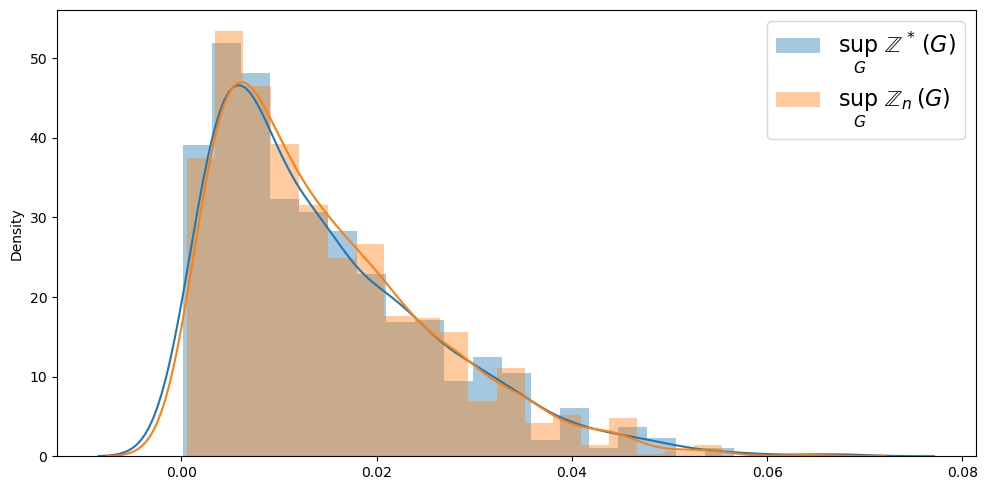

In [350]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.distplot(b_statistics.max(axis=1), label=f"$\sup_G\,\, \mathbb{{Z}}^*(G)$", ax=plt.gca())
sns.distplot(true_statistics,label="$\sup_G\,\, \mathbb{{Z}}_n(G)$", ax=plt.gca())
plt.legend(fontsize=16)
plt.tight_layout()
# plt.savefig(f'figures/bootstrap_calibration_{sample_size}.pdf')

/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_13317/1487234587.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(true_statistics,label="$\sup_G\,\, \{\hat{\epsilon}(G) - \epsilon(G)\}$", ax=plt.gca())


<AxesSubplot: ylabel='Density'>

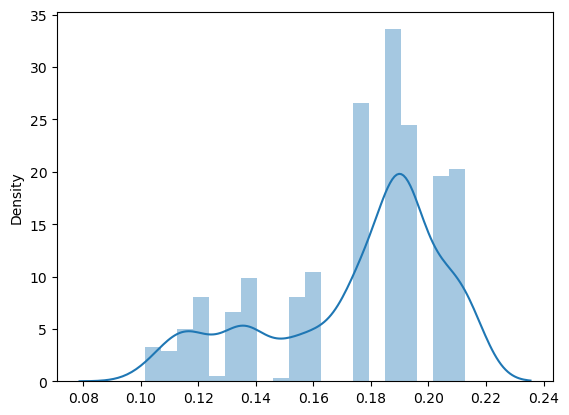

In [358]:
rng = np.random.default_rng(seed=0)

def generate_statistic(sample_size=1000):
    audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

    X = audit_trail_sample['x'].to_numpy()
    Y = audit_trail_sample['y'].to_numpy()
    Z1 = audit_trail_sample['z1'].to_numpy()
    Z2 = audit_trail_sample['z2'].to_numpy()
    
    coverage = (Y <= Z2) & (Y >= Z1)
        
    max_statistic = -np.inf
    
    for (x_min, x_max) in L_mapper.keys():
        x_filter = (X <= x_max) & (X >= x_min)
        subint = X[x_filter]
        
        L_n = np.mean(coverage * x_filter)
        P_n = np.mean(x_filter)
        L = L_mapper[(x_min, x_max)]
        P = P_mapper[(x_min, x_max)]
        if not np.isclose(P_n, 0):
            eps_hat = L_n / P_n
            eps = L / P
            statistic = eps_hat - eps
        else:
            statistic = -np.inf
        if statistic > max_statistic:
            max_statistic = statistic
    return max_statistic

sample_size = 500
true_statistics = [generate_statistic(sample_size) for i in range(1000)]

sns.distplot(true_statistics,label="$\sup_G\,\, \{\hat{\epsilon}(G) - \epsilon(G)\}$", ax=plt.gca())

In [359]:
from fairaudit.bootstrap import estimate_bootstrap_distribution

rng = np.random.default_rng(seed=1234)

audit_trail_sample = audit_trail.sample(n=sample_size, replace=True, random_state=rng)

s_idx = np.argsort(audit_trail_sample['x'])
X = audit_trail_sample['x'].to_numpy()[s_idx]
Y = audit_trail_sample['y'].to_numpy()[s_idx]
Z1 = audit_trail_sample['z1'].to_numpy()[s_idx]
Z2 = audit_trail_sample['z2'].to_numpy()[s_idx]
coverage = (Y <= Z2) & (Y >= Z1)

b_statistics = []
for b in tqdm(range(1000)):
    X_b = rng.choice(X, len(X)) 
    Y_b = rng.choice(Y, len(Y))
    Z1_b = rng.choice(Z1, len(Z1))
    Z2_b = rng.choice(Z2, len(Z2))
    
    coverage_b = (Y_b <= Z2_b) & (Y_b >= Z1_b)
        
    max_statistic = -np.inf
    
    for (x_min, x_max) in L_mapper.keys():
        x_filter_b = (X_b <= x_max) & (X_b >= x_min)        
        x_filter = (X <= x_max) & (X >= x_min)
         
        L_n = np.mean(coverage * x_filter)
        P_n = np.mean(x_filter)
        
        L_b = np.mean(coverage_b * x_filter_b)
        P_b = np.mean(x_filter_b)
        if not np.isclose(P_n, 0) and not np.isclose(P_b, 0):
            eps_hat = L_b / P_b
            eps = L_n / P_n
            statistic = eps_hat - eps
        else:
            statistic = -np.inf
        if statistic > max_statistic:
            max_statistic = statistic
    b_statistics.append(max_statistic)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.82it/s]


/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_13317/2158819257.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(b_statistics, label="$\sup_G\,\, \{\epsilon^*(G) - \hat{\epsilon}(G)\}$", ax=plt.gca())
/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_13317/2158819257.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/d

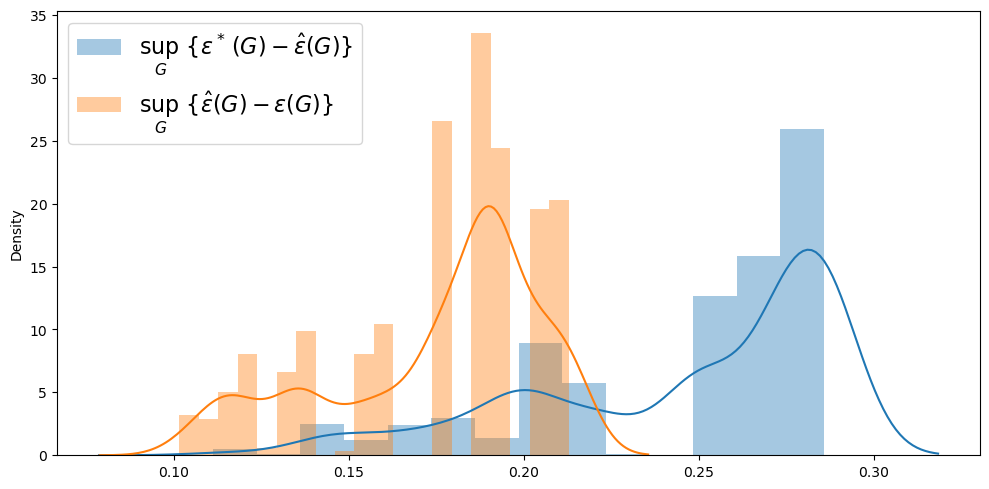

In [362]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.distplot(b_statistics, label="$\sup_G\,\, \{\epsilon^*(G) - \hat{\epsilon}(G)\}$", ax=plt.gca())
sns.distplot(true_statistics,label="$\sup_G\,\, \{\hat{\epsilon}(G) - \epsilon(G)\}$", ax=plt.gca())
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(f'figures/bootstrap_miscalibration_{sample_size}.pdf')